# Module 2: Regression Models to Predict Bus Arrival Delays

Student: Svavar Hrafn Ágústsson

Date: 31. Aug 2023

### Importing and Cleaning the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('Exercise2BusData.csv')
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)
df.head(10)

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,39,-4,28.641509
1,168,0,39,181,27.880597
2,231,0,39,244,27.852941
3,150,17,39,143,27.826087
4,965,35,51,947,42.029412
5,33,19,46,30,38.970588
6,75,26,46,63,38.840580
7,58,15,46,52,34.059701
8,904,35,46,888,34.102941
9,141,12,46,140,34.000000


Lets check if there are any missing values.

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_delay          2179 non-null   int64  
 1   Dwell_time             2179 non-null   int64  
 2   Scheduled_travel_time  2179 non-null   int64  
 3   Upstream_stop_delay    2179 non-null   int64  
 4   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 85.2 KB
None


Lets then explore the data

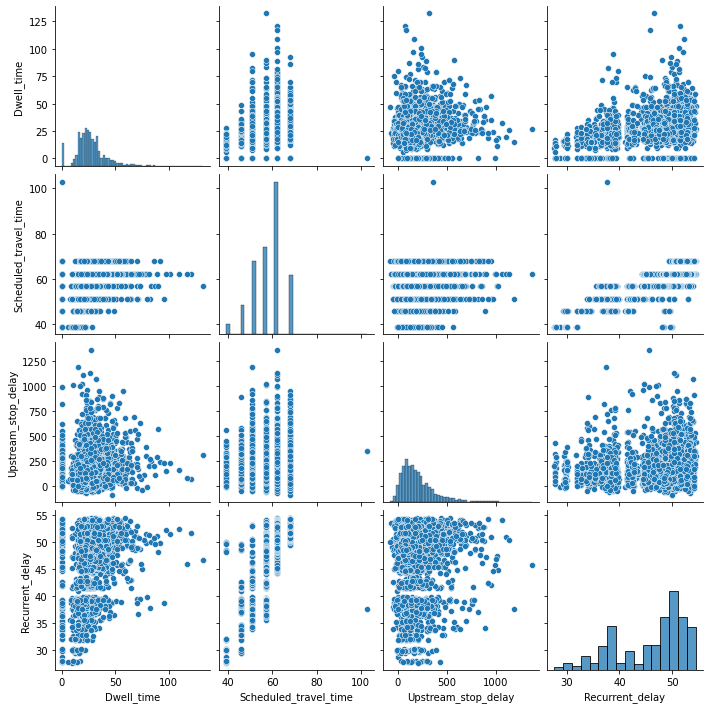

In [3]:
import seaborn as sns

sns.pairplot(df.drop(['Arrival_delay'], axis=1))

In [4]:
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

Arrival_delay            1.000000
Upstream_stop_delay      0.993935
Dwell_time               0.218745
Recurrent_delay          0.162692
Scheduled_travel_time    0.100695
Name: Arrival_delay, dtype: float64

# Training and prediction

Lets start by defining both the features to model and the target. Lets then scale the features to reduce training time.

In [5]:
features = df.drop('Arrival_delay', axis=1)
target = df['Arrival_delay']

# Scaling the features.
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Next lets split the data into training and testing data and define the xGBoost regressor.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor()

Lets us grid search to optimize the xGB model due to the reletivly small df. 

In [7]:
# Hyperparameters for grid search.
param_grid = {
    'n_estimators': [ 100, 150,200],
    'learning_rate': [ 0.05, 0.1,0.2],
    'max_depth': [ 5, 7,9],
    'colsample_bytree': [ 0.9,1],
    'gamma': [ 0.1, 0.2,.3]
}

# Using GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ",grid_search.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 1, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


# Evaluate the Model

Lets evaluate the models performance.

Mean Absolute Error: 10.573279413539883
Mean Squared Error: 208.61901359667408
Root Mean Squared Error: 208.61901359667408
R-squared: 0.9930040475317099


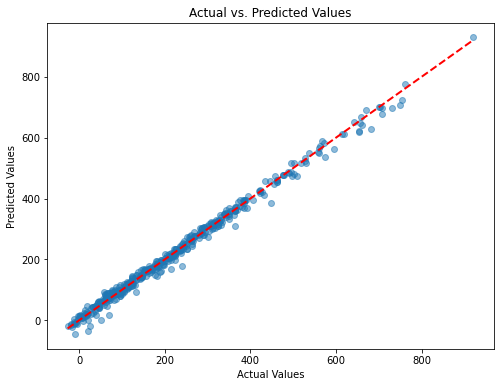

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_xgb_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculating and displaying the MAE, MSE and R2.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

We see that the model is excellent at predicting and giving better results than the  simple regression model.